In [3]:
%load_ext blackcellmagic

In [4]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)
from keras.datasets import mnist, fashion_mnist, cifar10, cifar100
from keras.layers import (
    Conv2D,
    Dense,
    Flatten,
    Input,
    MaxPooling2D,
    Reshape,
    UpSampling2D,
)
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [5]:
#CIFAR_10 = cifar10.load_data()
#CIFAR_100 = cifar100.load_data()
#MNIST = mnist.load_data()
FASHION_MNIST = fashion_mnist.load_data()

In [6]:
# this is the size of our encoded representations
ENCODING_DIM = 10

# decision boundary for classifier
THRESHOLD = 0.7

# working directory
CUR_DIR = os.path.abspath(os.path.curdir)

# setting random seed for reproducable results
np.random.seed(42)

In [7]:
def train_test_split(X, y, train_split=0.7, test_split=0.85):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    # define boundaries for train,validation and test set at .7 and .85 % of the MNIST data set
    x_len = len(X)
    boundaries = [int(x_len * train_split), int(x_len * test_split)]

    [X_train, X_test, X_validate] = np.split(X, boundaries)

    [y_train, y_test, y_validate] = np.split(y, boundaries)
    return (X_train, X_test, X_validate), (y_train, y_test, y_validate)

In [8]:
def get_data(dataset, train_split=0.7, test_split=0.85):
    """retrieves data set and rebalances dataset, such that train=.7, test=.15 and validation=.15.
    :param dataset is assumed to be loaded from keras.datasets, thus the from 2-tuple(2-tuple) is assumed."""
    if not (len(dataset) == 2 and all([len(d) == 2 for d in dataset])):
        raise ValueError(
            "Datset has not the correct form. Please load from keras.datasets or convert to similar form."
        )

    (X_train, y_train), (X_test, y_test) = dataset
    if len(X_train.shape) == 3: # MNIST data set
        X_train = X_train.reshape((list(X_train.shape) + [1])) /255.0
        test_len = len(X_test)
        X_test = X_test.reshape((list(X_test.shape) + [1])) / 255.0

    # divide X values bei 255.0 since MNIST data set changed such that pixel values are in [0,255]
    X = np.concatenate((X_train, X_test)) 
    y = np.concatenate((y_train, y_test))

    (X_train, X_test, X_validate), (y_train, y_test, y_validate) = train_test_split(
        X, y
    )  # default: .7, .85
    # one-hot encode target columns
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    y_validate = to_categorical(y_validate)

    return (X_train, X_test, X_validate), (y_train, y_test, y_validate)

In [9]:
(X_train, X_test, X_validate), (y_train, y_test, y_validate) = get_data(FASHION_MNIST)
#plt.imshow(X_train[3].reshape((28,28)),cmap="gray")

In [10]:
X_train[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.00392157],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.03137255],
        [0.4745098 ],
        [0.37254902],
        [0.23921569],
        [0.24705882],
        [0.34117647],
        [0.38431373],
        [0.65882353],
        [0.65882353],
        [0.07843137],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.15294118],
        [0.4       ],
        [0.40784314],
        [0.75686275],
        [0.8       ],
        [0.83137255],
        [0.84705882],
        [0.89019608],
        [0.99607843],
        [0.91372549],
        

In [11]:
def get_specific_data_set(X, y, fashion):
    # parameters are training AND test data for X respectively y
    # is assumed to be in one-hot-encoding
    y = np.argmax(y, axis=1)
    indices = np.where(y == fashion)

    # filtering by the passed fashion. needs to be an int
    X_fashion = X[indices]
    y_fashion = y[indices]

    y_fashion = to_categorical(y_fashion)  # array of length 2 of form [0., 1.]

    # splitting into training and test set is not necessary since the data for single fashions
    # is just used for evaluation purposes (except for "1")

    return [X_fashion, y_fashion]

In [12]:
X = np.concatenate((X_train, X_test, X_validate))
y = np.concatenate((y_train, y_test, y_validate))
X.shape, y.shape

((70000, 28, 28, 1), (70000, 10))

In [13]:
# fashion = 0
# X_zero, y_zero = get_specific_data_set(X, y, fashion)
# fashion = 8
# X_eight, y_eight = get_specific_data_set(X, y, fashion)
# fashion = 1
# X_one, y_one =  get_specific_data_set(X, y, fashion)
# fashion = 7
# X_seven, y_seven = get_specific_data_set(X, y, fashion)
fashion_data = [get_specific_data_set(X, y, i) for i in range(10)]

all_fashions = X[np.where(np.argmax(y,axis=1)!= 1)]

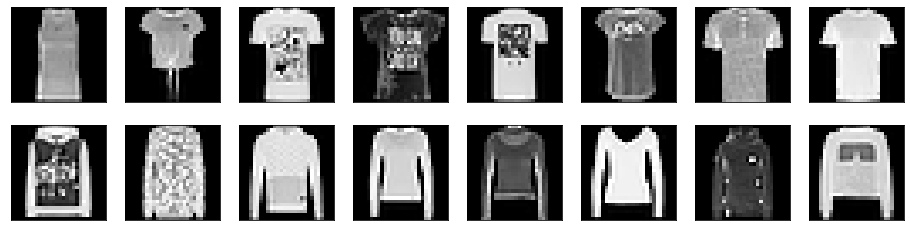

In [14]:
plt.figure(figsize=(16, 4))
for i in range(len(fashion_data[1][0][0]))[:8]:
    ax = plt.subplot(2, 8, i+1)
    plt.imshow(fashion_data[0][0][i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
for i in range(len(fashion_data[1][0][0]))[:8]:
    ax = plt.subplot(2, 8, 8+i+1)
    plt.imshow(fashion_data[2][0][i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [15]:
def build_classifier(input_dim):
    """Builds classifier for classification of MNIST encoded representation."""
    classifier = Sequential()
    classifier.add(Dense(32, activation="relu", input_dim=input_dim,
                         kernel_initializer="random_normal"))
    classifier.add(Dense(ENCODING_DIM, activation="softmax",
                         kernel_initializer="random_normal"))

    classifier.compile(optimizer='adam', loss='mean_squared_error',
                       metrics=['accuracy'])
    return classifier

In [16]:
def build_conv_aue():
    INPUT_SHAPE = (28, 28, 1)
    DEFAULT_KERNEL = (3, 3)
    DEFAULT_POOL_SIZE = (3, 3)
    # this is our input placeholder
    input_img = Input(shape=INPUT_SHAPE)
    # layer between input and middle layer
    encode = Conv2D(64, DEFAULT_KERNEL, activation="relu", padding="same")(input_img)
    encode = MaxPooling2D(DEFAULT_POOL_SIZE, padding="same")(encode)
    encode = Conv2D(64, DEFAULT_KERNEL, activation="relu", padding="same")(encode)
    encode = MaxPooling2D(DEFAULT_POOL_SIZE, padding="same")(encode)
    encode = Conv2D(1, DEFAULT_KERNEL, activation="relu", padding="same")(encode)

    # "encoded" is the encoded representation of the input, middle layer of the aue
    encoded = MaxPooling2D(DEFAULT_POOL_SIZE, padding="same", name="encoder")(encode)

    # layer between middle and output layer
    decode = Conv2D(1, DEFAULT_KERNEL, activation="relu", padding="same")(encoded)
    decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    decode = Conv2D(64, DEFAULT_KERNEL, activation="relu")(decode)
    decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    decode = Conv2D(64, DEFAULT_KERNEL, activation="relu")(decode)
    decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    # decode = Conv2D(16, DEFAULT_KERNEL, activation="relu")(decode)
    # decode = UpSampling2D(DEFAULT_POOL_SIZE)(decode)
    #decode = Conv2D(1,DEFAULT_KERNEL,activation="sigmoid")(decode)
    decoded = Conv2D(1, DEFAULT_KERNEL, activation="sigmoid")(decode)

    # this model maps an input to its reconstruction
    autoencoder = Model(inputs=input_img, outputs=decoded)

    encoder, decoder = get_codec_from_aue(autoencoder)

    # build (aka "compile") the model
    autoencoder.compile(optimizer="adam", loss="mean_squared_error")
    return autoencoder, encoder, decoder

In [17]:
def get_codec_from_aue(autoencoder):
    encoder_layer = autoencoder.get_layer("encoder")
    # this model maps an input to its encoded representation; Big image to small rep
    encoder = Model(
        inputs=autoencoder.input, outputs=encoder_layer.output)

    # create a placeholder for an encoded (ENCODING_DIM-dimensional) input
    encoded_input = Input(shape=encoder_layer.output_shape[1:])

    # getting the middle of the autoencoder
    start = (len(autoencoder.layers))//2
    decoder = autoencoder.layers[-start](encoded_input)
    # stacking the decoder layers
    for i in range(start-1, 0, -1):
        decoder = autoencoder.layers[-i](decoder)

    # create the decoder model; "<": encoded(small) representation to big image
    decoder = Model(encoded_input, decoder)
    return encoder, decoder

In [18]:
# array to map inidices to description of the corresponding index
fashion_verbose = [
    "t-shirt",
    "trousers",
    "pullover",
    "dress",
    "coat",
    "sandal",
    "shirt",
    "sneaker",
    "bag",
    "ankle boot",
]

**all fashion auto encoder**

In [19]:
ckpt_loc = os.path.join(CUR_DIR, "ckpts", "fashionall-conv-ae.hdf5")

if False and os.path.isfile(ckpt_loc):
    print("Loading Autoencoder for all fashions from directory %s..." % ckpt_loc)
    all_ae = load_model(ckpt_loc)
    all_encoder, all_decoder = get_codec_from_aue(all_ae)
else:
    print("Training Autoencoder for all fashions...")
    all_ae, all_encoder, all_decoder = build_conv_aue()
    earlyStopping = EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, mode="min", min_delta=0.0001
    )
    mcp_save = ModelCheckpoint(
        ckpt_loc, save_best_only=True, verbose=1, monitor="val_loss", mode="min"
    )
    reduce_lr_loss = ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, verbose=1, mode="min"
    )
    tb = TensorBoard(
        log_dir="./logs/all-fashion", histogram_freq=0, write_graph=True, write_images=True, update_freq="batch"
    )
    all_ae.fit(
        X_train,
        X_train,
        epochs=128,
        batch_size=128,
        shuffle=True,
        validation_data=(X_validate, X_validate),
        callbacks=[earlyStopping, mcp_save, reduce_lr_loss,tb],
    )
all_ae.summary()

Loading Autoencoder for all fashions from directory C:\Users\a642196\coding\CNN-auto-encoder\ckpts\fashionall-conv-ae.hdf5...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
____________________________

In [20]:
eval_train = all_ae.evaluate(X_train, X_train)
eval_validate = all_ae.evaluate(X_validate, X_validate)
eval_test = all_ae.evaluate(X_test, X_test)
eval_train, eval_validate,eval_test

10500/10500 [==============================] - 4s 422us/step


(0.32511209767205373, 0.3262432733603886, 0.3263651951494671)

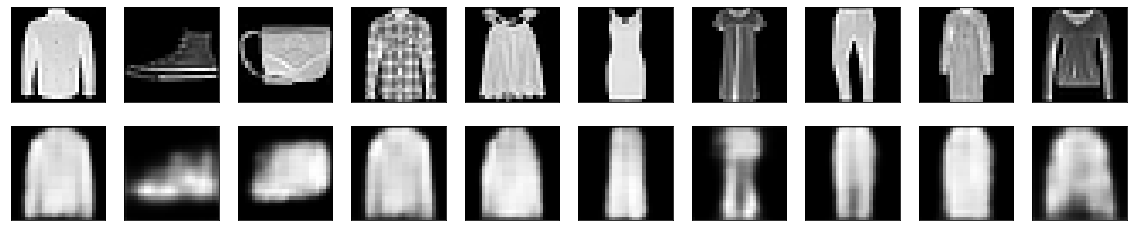

In [21]:
encoded_imgs_train = all_encoder.predict(X_train)
encoded_imgs_validate = all_encoder.predict(X_validate)
encoded_imgs_test = all_encoder.predict(X_test)

decoded_imgs = all_decoder.predict(encoded_imgs_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(os.path.join("imgs", "all-fashion-conv-ae.png"))

**"one" auto encoder**

Learning features of t shirts (label:0). Afterwards, the distribution of the features will be computed to detect outliers which have low probability.

In [22]:
X_t = fashion_data[0][0]
y_t = fashion_data[0][1]

(X_t_train, X_t_test, X_t_validate), (
    y_t_train,
    y_t_test,
    y_t_validate,
) = train_test_split(X_t, y_t)
len(X_t_train), len(X_t_test), len(X_t_validate)

(4900, 1050, 1050)

In [89]:
ckpt_loc = os.path.join(CUR_DIR, "ckpts", "%s-conv-ae.hdf5" % fashion_verbose[0])

if False and os.path.isfile(ckpt_loc):
    print("Loading Autoencoder %s from directory %s..." % (fashion_verbose[0], ckpt_loc))
    t_ae = load_model(ckpt_loc)
    t_encoder, t_decoder = get_codec_from_aue(t_ae)
else:
    print("Training Autoencoder for fashion %s..." % fashion_verbose[0])
    t_ae, t_encoder, t_decoder = build_conv_aue()
    earlyStopping = EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, mode="min", min_delta=0.0001
    )
    mcp_save = ModelCheckpoint(
        ckpt_loc, save_best_only=True, verbose=1, monitor="val_loss", mode="min"
    )
    reduce_lr_loss = ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, verbose=1, mode="min"
    )
    tb = TensorBoard(
        log_dir="./logs/t-shirt", histogram_freq=0, write_graph=True, write_images=True, update_freq="batch"
    )
    t_ae.fit(
        X_t_train,
        X_t_train,
        epochs=128,
        batch_size=128,
        shuffle=True,
        validation_data=(X_t_validate, X_t_validate),
        callbacks=[earlyStopping, mcp_save, reduce_lr_loss, tb],
    )
t_ae.summary()

Training Autoencoder for fashion t-shirt...
Train on 4900 samples, validate on 1050 samples
Epoch 1/128
4900/4900 [==============================] - 29s 6ms/step - loss: 0.5823 - val_loss: 0.4880

Epoch 00001: val_loss improved from inf to 0.48798, saving model to C:\Users\a642196\coding\CNN-auto-encoder\ckpts\t-shirt-conv-ae.hdf5
Epoch 2/128
4900/4900 [==============================] - 26s 5ms/step - loss: 0.4466 - val_loss: 0.4773

Epoch 00002: val_loss improved from 0.48798 to 0.47727, saving model to C:\Users\a642196\coding\CNN-auto-encoder\ckpts\t-shirt-conv-ae.hdf5
Epoch 3/128
4900/4900 [==============================] - 27s 5ms/step - loss: 0.4261 - val_loss: 0.4039

Epoch 00003: val_loss improved from 0.47727 to 0.40393, saving model to C:\Users\a642196\coding\CNN-auto-encoder\ckpts\t-shirt-conv-ae.hdf5
Epoch 4/128
4900/4900 [==============================] - 26s 5ms/step - loss: 0.4048 - val_loss: 0.3993

Epoch 00004: val_loss improved from 0.40393 to 0.39929, saving model to 

4900/4900 [==============================] - 24s 5ms/step - loss: 0.3412 - val_loss: 0.3430

Epoch 00075: val_loss did not improve from 0.34294
Epoch 76/128
4900/4900 [==============================] - 22s 5ms/step - loss: 0.3411 - val_loss: 0.3433

Epoch 00076: val_loss did not improve from 0.34294
Epoch 77/128
4900/4900 [==============================] - 22s 5ms/step - loss: 0.3410 - val_loss: 0.3430

Epoch 00077: val_loss did not improve from 0.34294

Epoch 00077: ReduceLROnPlateau reducing learning rate to 0.027000001072883605.
Epoch 78/128
4900/4900 [==============================] - 23s 5ms/step - loss: 0.3408 - val_loss: 0.3426

Epoch 00078: val_loss improved from 0.34294 to 0.34255, saving model to C:\Users\a642196\coding\CNN-auto-encoder\ckpts\t-shirt-conv-ae.hdf5
Epoch 79/128
4900/4900 [==============================] - 23s 5ms/step - loss: 0.3408 - val_loss: 0.3425

Epoch 00079: val_loss improved from 0.34255 to 0.34253, saving model to C:\Users\a642196\coding\CNN-auto-encod

In [90]:
eval_t_train = t_ae.evaluate(X_t_train, X_t_train)
eval_t_validate = t_ae.evaluate(X_t_validate, X_t_validate)
eval_t_test = t_ae.evaluate(X_t_test, X_t_test)
eval_t_train, eval_t_validate, eval_t_test

1050/1050 [==============================] - 2s 2ms/step


(0.3405600168996928, 0.34232312463578723, 0.3438330984683264)

In [91]:
encoded_t_imgs_train = t_encoder.predict(X_t_train)
encoded_t_imgs_validate = t_encoder.predict(X_t_validate)
encoded_t_imgs_test = t_encoder.predict(X_t_test)

## Reconstructed "t-shirts" with auto encoder

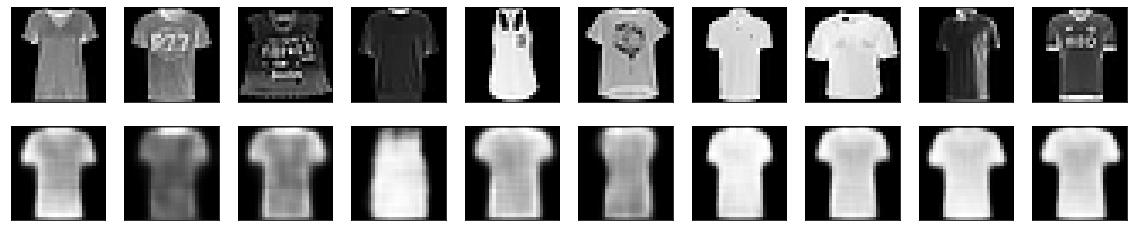

In [92]:
decoded_t_imgs = t_decoder.predict(encoded_t_imgs_train)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_t_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_t_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(os.path.join("imgs", "t-conv-ae.png"))

## Reconstructed "pullover" (aka anomaly) with auto encoder

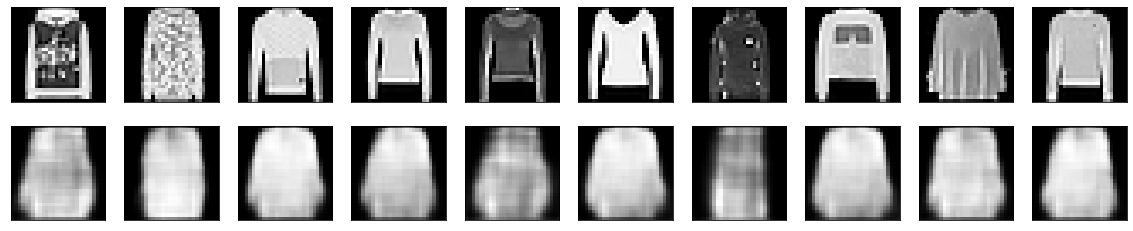

In [93]:
decoded_pullover_imgs = t_ae.predict(fashion_data[2][0])
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(fashion_data[2][0][i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_pullover_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(os.path.join("imgs", "pullover-conv-t-ae.png"))

## Anomaly detection with root of squared loss per pixel

In [94]:
def loss_per_img(img,rec_img):
    return np.sqrt(np.sum(np.power(rec_img - img,2)))

In [95]:
pullover = fashion_data[2][0][:len(fashion_data[2][0])//50]
imgs = pullover.reshape(-1, 28, 28, 1)
rec_imgs = t_ae.predict(imgs)
pullover_losses = np.array([loss_per_img(i, ri) for i, ri in zip(imgs, rec_imgs)])

imgs = all_fashions#.reshape(-1,28,28,1)
rec_imgs = t_ae.predict(imgs)
all_fashions_losses = np.array([loss_per_img(i,ri) for i,ri in zip(imgs,rec_imgs)])

pullover_losses.max(), pullover_losses.mean()

(8.992531561521238, 5.453228970389048)

In [96]:
normal_losses = np.array([])
imgs = X_t_test.reshape(len(X_t_test),28,28,1)
rec_imgs = t_ae.predict(imgs)
normal_losses = np.array([loss_per_img(i,ri) for i,ri in zip(imgs,rec_imgs)])

normal_losses.max(), normal_losses.mean()

(9.585931423036573, 3.4948974690044086)

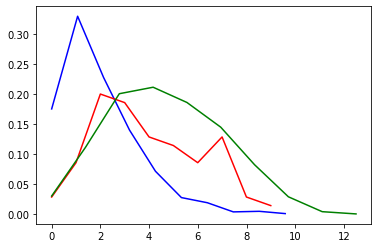

In [97]:
# loss distribution over the normal dataset
bins = 10
t = np.linspace(0, normal_losses.max(), bins)
hist_normal = np.histogram(normal_losses, bins=bins)
plt.plot(t, hist_normal[0] / len(normal_losses), "b")

# loss distribution over the anomaly dataset for fashion "pullover"
hist_pullovers = np.histogram(pullover_losses, bins=bins)
t = np.linspace(0, pullover_losses.max(), bins)
plt.plot(t, hist_pullovers[0] / len(pullover_losses), "r")

# loss distribution over the anomaly dataset for all fashions
hist_all = np.histogram(all_fashions_losses, bins=bins)
t = np.linspace(0, all_fashions_losses.max(), bins)
plt.plot(t, hist_all[0] / len(all_fashions_losses), "g")
plt.show()

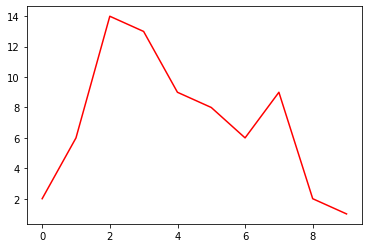

In [98]:
# loss distribution over the anomaly dataset
bins = 10
hist_anomaly = np.histogram(pullover_losses, bins=bins)
t = np.linspace(0, pullover_losses.max(), bins)
plt.plot(t, hist_anomaly[0], "r")
plt.show()

i:0.200, ratio:0.000, dn:0.800000 + ua:0.000000 = 0.800000
i:0.210, ratio:0.000, dn:0.790476 + ua:0.000000 = 0.790476
i:0.220, ratio:0.000, dn:0.780000 + ua:0.000000 = 0.780000
i:0.230, ratio:0.014, dn:0.770476 + ua:0.014286 = 0.784762
i:0.240, ratio:0.014, dn:0.760000 + ua:0.014286 = 0.774286
i:0.250, ratio:0.014, dn:0.750476 + ua:0.014286 = 0.764762
i:0.260, ratio:0.014, dn:0.740000 + ua:0.014286 = 0.754286
i:0.270, ratio:0.014, dn:0.730476 + ua:0.014286 = 0.744762
i:0.280, ratio:0.014, dn:0.720000 + ua:0.014286 = 0.734286
i:0.290, ratio:0.014, dn:0.710476 + ua:0.014286 = 0.724762
i:0.300, ratio:0.014, dn:0.700000 + ua:0.014286 = 0.714286
i:0.310, ratio:0.014, dn:0.690476 + ua:0.014286 = 0.704762
i:0.320, ratio:0.014, dn:0.680000 + ua:0.014286 = 0.694286
i:0.330, ratio:0.014, dn:0.670476 + ua:0.014286 = 0.684762
i:0.340, ratio:0.014, dn:0.660000 + ua:0.014286 = 0.674286
i:0.350, ratio:0.014, dn:0.650476 + ua:0.014286 = 0.664762
i:0.360, ratio:0.014, dn:0.640000 + ua:0.014286 = 0.6542

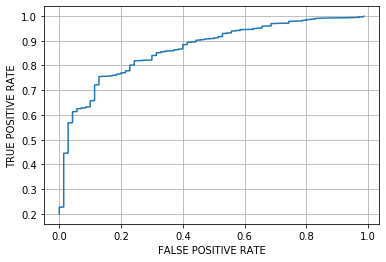

0.7670000000000002

In [99]:
# x:= "false detected anomalies in %"
# y:= "correct detected normal data points in %"
FPs = FNs = []
prec = 1000
step_size = 1.0 / prec
thresholds = np.arange(0.5, 1, step_size)

for i in thresholds:  # i == 0.95 seems to be a valid value
    loss_boundary = np.sort(normal_losses)[
        int(len(normal_losses) * i)
    ]  # loss value for detection of i% normal data points
    ind_undetected_anomalies = np.where(
        pullover_losses < loss_boundary
    )  # indices for undetected anomalies in the data set
    ind_detected_normals = np.where(
        normal_losses >= loss_boundary
    )  # indices for as anomaly detected normal data points in the data set
    detected_normals = X_t_test[ind_detected_normals]
    undetected_anomalies = fashion_data[2][0][ind_undetected_anomalies]

    FP_rate = len(undetected_anomalies) / len(
        pullover_losses
    )  # ratio between not detected loss values for anomalies
    rs = np.append(
        rs, [ratio_of_undetected]
    )
    if (int(i * prec)) % int(prec / 100) == 0:
        print(
            "threshold:%.3f,dn:%f + ua:%f = %f"
            % (i, FN_rate, FP_rate, FN_rate + FP_rate)
        )
plt.plot(FPs, thresholds)
plt.grid()
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.show()
loss_threshold = thresholds[
    np.argmin(FNs + FPs)
]  # minimum value for FN_rate + FP_rate (least relative amount of falsely detected)
loss_threshold

In [100]:
len(normal_losses), len(pullover_losses)

(1050, 70)

In [101]:
loss_boundary = np.sort(normal_losses)[int(len(normal_losses) * loss_threshold)]
ind_undetected_anomalies = np.where(
    pullover_losses < loss_boundary
)  # indices for undetected anomalies in the data set
ind_detected_normals = np.where(
    normal_losses >= loss_boundary
)  # indices for as anomaly detected normal data points in the data set

detected_normals = X_t_test[ind_detected_normals]
undetected_anomalies = fashion_data[2][0][ind_undetected_anomalies]
loss_boundary, len(detected_normals), len(undetected_anomalies)

(4.360657365012842, 200, 17)

ValueError: num must be 1 <= num <= 15, not 16

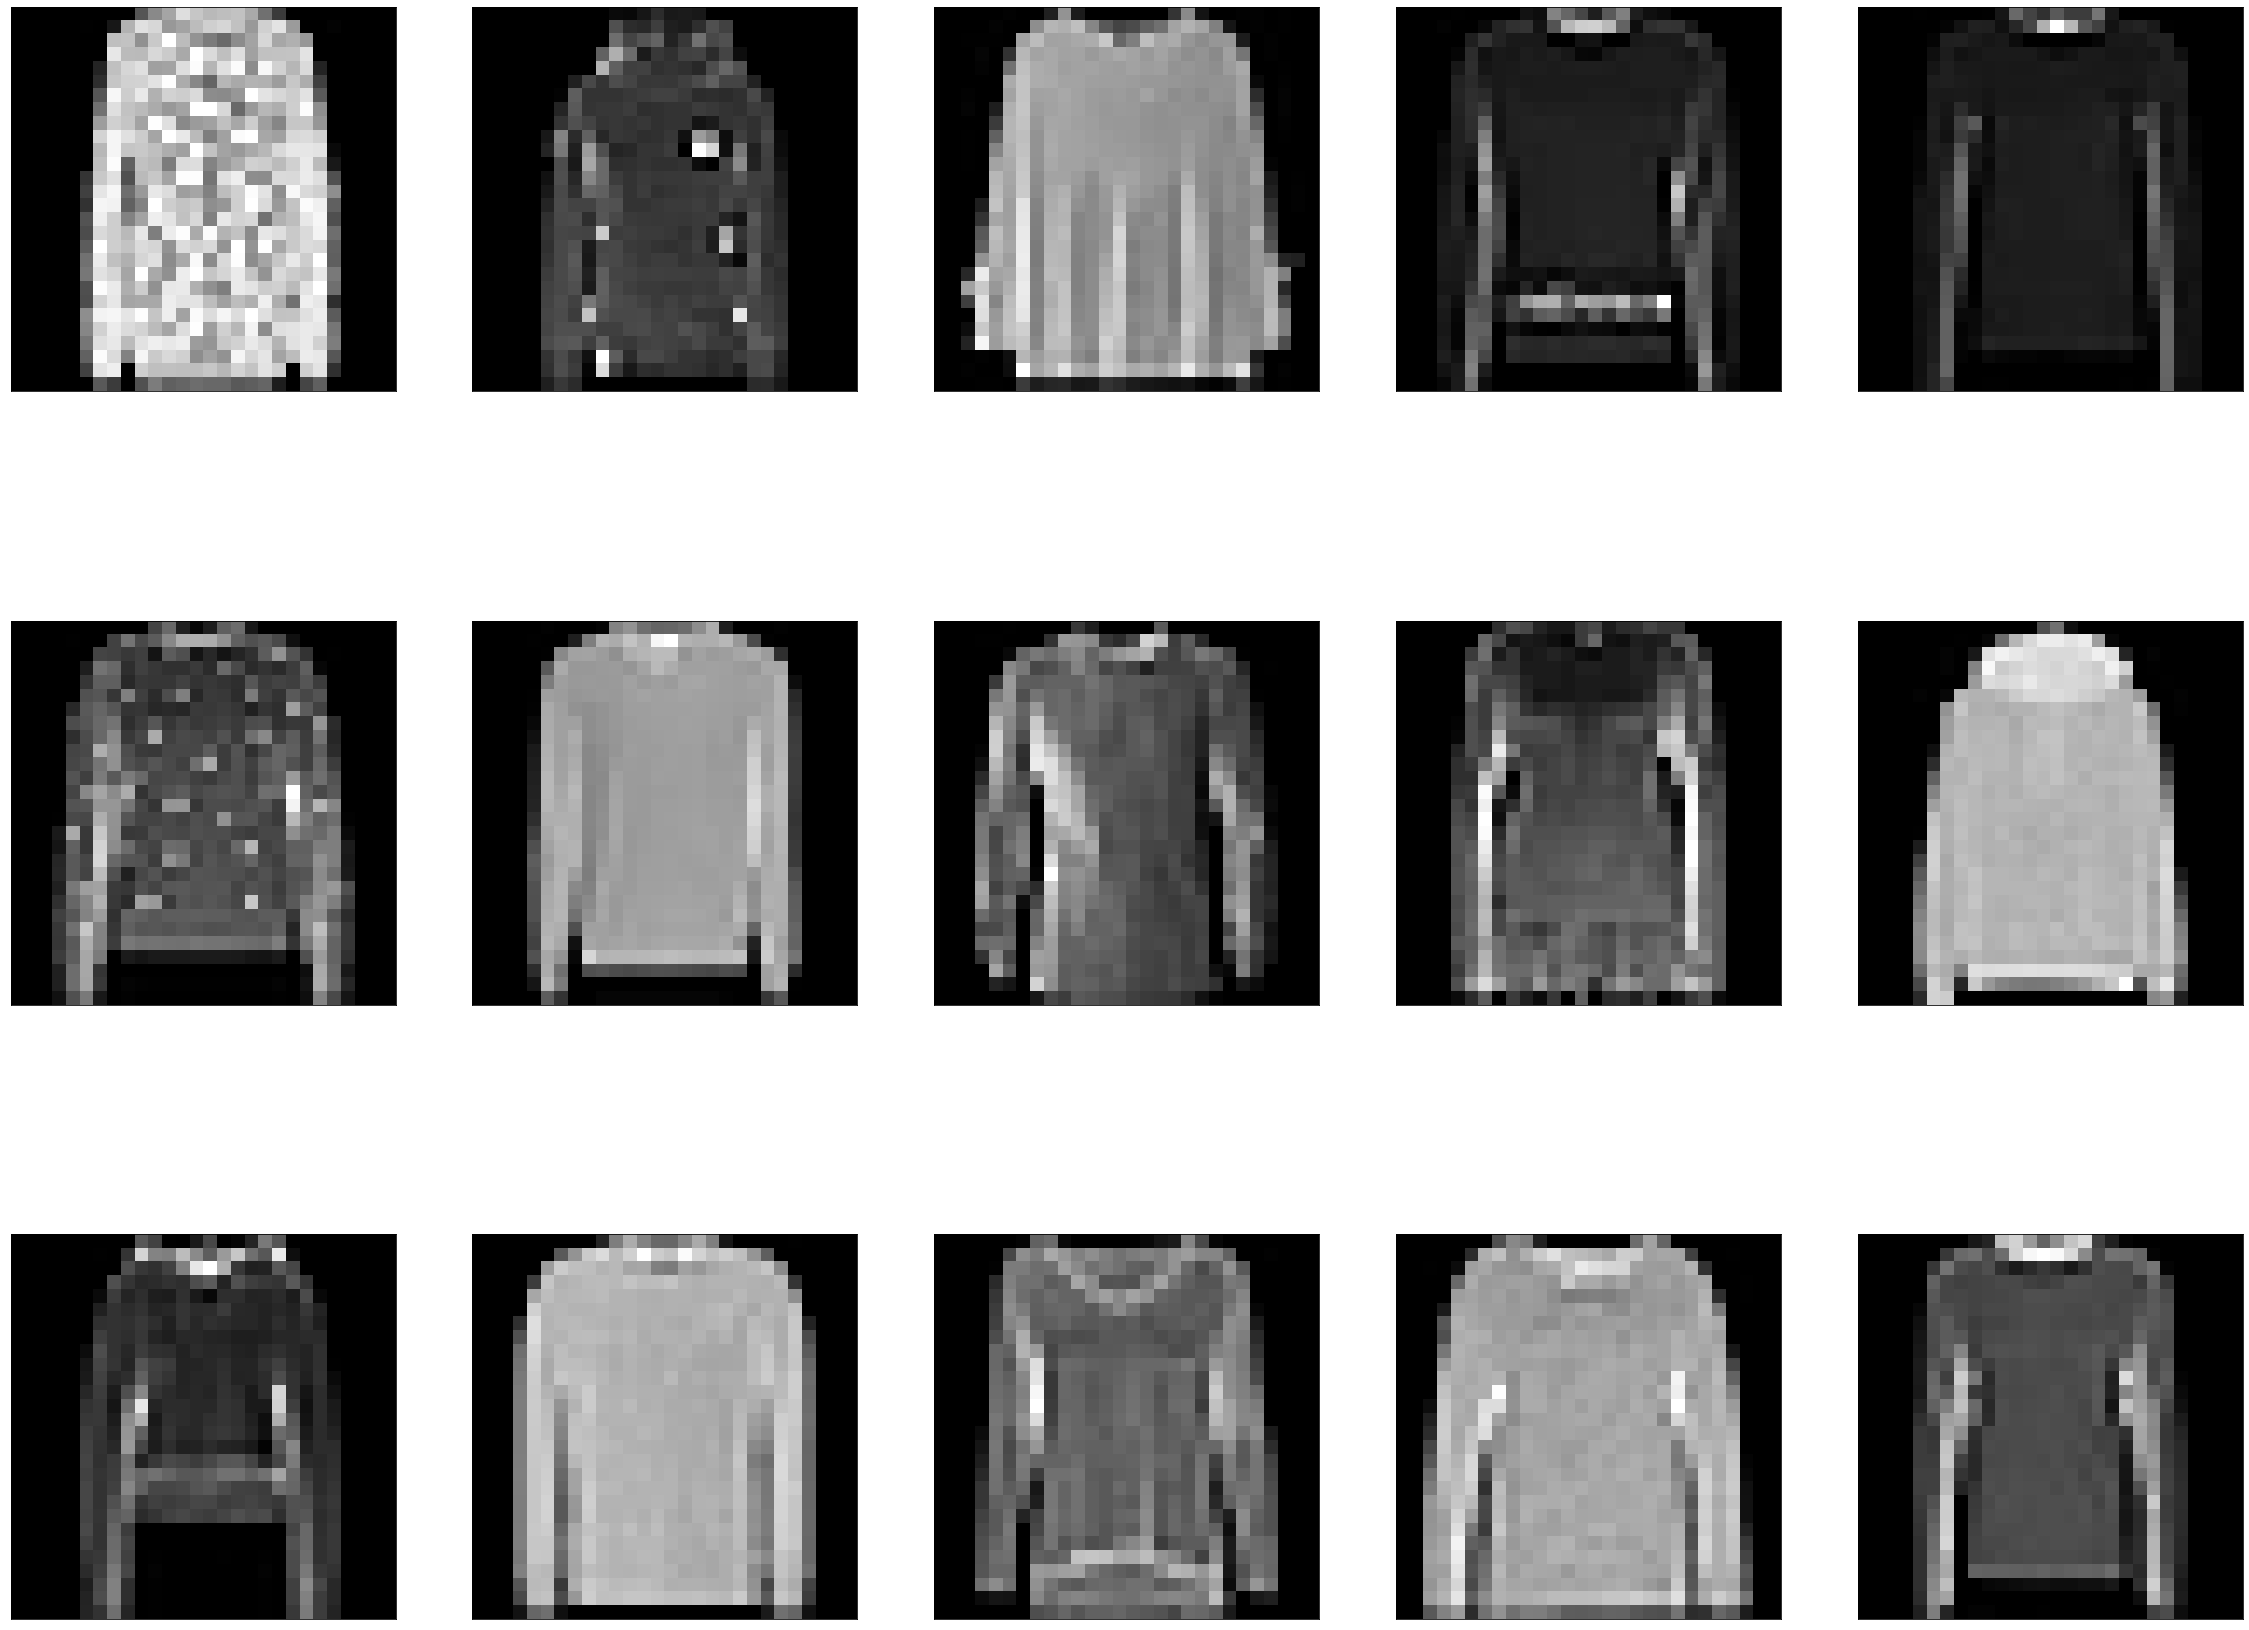

In [102]:
# displays all pullovers which were not detected as such ("anomalies")
n = len(undetected_anomalies)  # how many digits we will display
plt.figure(figsize=(40, 32))
for i in range(n):
    ax = plt.subplot(n/3, n, i + 1)
    plt.imshow(undetected_anomalies[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(os.path.join("imgs", "undetected-pullover.png"))

In [ ]:
# display t-shirts which have been detectes as normaility 
n = min(len(detected_normals),20)  # how many digits we will display
plt.figure(figsize=(40, 32))
for i in range(n):
    ax = plt.subplot(n//5, n//4, i + 1)
    plt.imshow(detected_normals[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(os.path.join("imgs", "detected-t-shirts.png"))

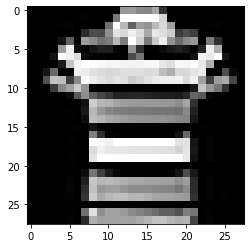

In [38]:
plt.imshow(X_t_test[np.argmax(normal_losses)].reshape((28,28)))
plt.show()

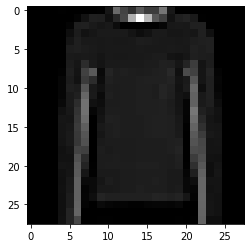

In [39]:
plt.imshow(fashion_data[2][0][np.argmin(pullover_losses)].reshape((28,28)))
plt.show()

# Anomaly Detector
This anomaly detector should be able to seperate images of the handwritten digits $1$ and $7$.

In [40]:
def is_anomaly(ae, x):
    x = x.reshape((1,28,28,1))
    pred = ae.predict(x)
    loss = np.sum(pred - x) **2 # squared loss => positive value

## All fashion classifier

In [52]:
flat = np.prod(encoded_imgs_train.shape[1:], dtype=np.int64)
encoded_imgs_train = encoded_imgs_train.reshape(len(encoded_imgs_train), flat)
encoded_imgs_validate = encoded_imgs_validate.reshape(
    len(encoded_imgs_validate), flat)
encoded_imgs_test = encoded_imgs_test.reshape(len(encoded_imgs_test), flat)

In [42]:
ckpt_loc = os.path.join(CUR_DIR, "ckpts", "fashion-classifier.hdf5")
if os.path.isfile(ckpt_loc):
    print("Loading classifier from directory %s..." % ckpt_loc)
    classifier = load_model(ckpt_loc)
else:
    print("Training classifier...")
    classifier = build_classifier(input_dim=flat)
    earlyStopping = EarlyStopping(
        monitor="val_acc", patience=5, verbose=1, mode="max", min_delta=0.0005
    )
    mcp_save = ModelCheckpoint(
        ckpt_loc, save_best_only=True, verbose=1, monitor="val_acc", mode="max"
    )
    reduce_lr_loss = ReduceLROnPlateau(
        monitor="val_acc", factor=0.3, patience=3, verbose=1, mode="max"
    )
    classifier.fit(
        encoded_imgs_train,
        y_train,
        validation_data=(encoded_imgs_validate, y_validate),
        batch_size=16,
        epochs=32,
        shuffle=True,
        callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
    )

Loading classifier from directory C:\Users\a642196\coding\CNN-auto-encoder\ckpts\classifier.hdf5...


In [43]:
eval_train = classifier.evaluate(encoded_imgs_train, y_train)
eval_validate = classifier.evaluate(encoded_imgs_validate, y_validate)
eval_test = classifier.evaluate(encoded_imgs_test, y_test)
eval_train,eval_validate, eval_test

10500/10500 [==============================] - 0s 46us/step


([0.15869562481860724, 0.09187755102040816],
 [0.15886225703784398, 0.09038095238095238],
 [0.15810579624630156, 0.09457142857142857])

In [44]:
def get_cm(input, y_true):
    """Computes confusion matrix."""
    y_pred = tf.argmax(classifier.predict(input), axis=1)
    y_true = tf.argmax(y_true, axis=1)

    c = tf.keras.backend.eval(y_pred)
    d = tf.keras.backend.eval(y_true)

    return confusion_matrix(c, d)

In [45]:
def precision(cm):
    results = []
    for i in range(len(cm)):  # rows
        TP = cm[i][i]
        fp_tp = np.sum(cm[i])
        results.append(TP / fp_tp)
    return results + [np.mean(results)]

In [46]:
def recall(cm):
    results = []
    for i in range(len(cm)):  # rows
        TP = cm[i][i]
        tp_fn = 0
        for j in range(len(cm[i])):
            tp_fn += cm[j][i]
        results.append(TP/tp_fn)
    return results + [np.mean(results)]

In [47]:
cm_train = get_cm(encoded_imgs_train, y_train)
print(cm_train, precision(cm_train)[-1], recall(cm_train)[-1], sep="\n")

cm_validate = get_cm(encoded_imgs_validate, y_validate)
print(cm_validate, precision(cm_validate)[-1], recall(cm_validate)[-1], sep="\n")

cm_test = get_cm(encoded_imgs_test, y_test)
print(cm_test, precision(cm_test)[-1], recall(cm_test)[-1], sep="\n")

C:\Users\a642196\.conda\envs\tf_env\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in longlong_scalars
  


[[   0    0    0    0    0    0    0    0    0    0]
 [   3   69    2   63    2    0    3    0    1    0]
 [ 794  211 4349  310 3905 4876 3162 4892 4556 4951]
 [   3    0    0    2    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [3838 1190  552 2572  878    2 1656    0  319    0]
 [ 221 3413    6 1978  138    0   80    0    1    0]
 [   0    1    0    1    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]
nan
0.09171907899110257
[[   0    0    0    0    0    0    0    0    0    0]
 [   0   21    1   12    0    0    2    0    0    0]
 [ 168   41  916   74  795 1095  698 1059 1008 1005]
 [   1    0    0    0    1    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [ 828  236  109  556  195    1  364    0   74    0]
 [  57  759    1  378   34    0   11    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0

# Anomaly Detection with DJ CF Gauss

In [55]:
t_flat = np.prod(encoded_t_imgs_train.shape[1:], dtype=np.int64)
encoded_t_imgs_train = encoded_t_imgs_train.reshape(
    len(encoded_t_imgs_train), t_flat
)
encoded_t_imgs_validate = encoded_t_imgs_validate.reshape(
    len(encoded_t_imgs_validate), t_flat
)
encoded_t_imgs_test = encoded_t_imgs_test.reshape(
    len(encoded_t_imgs_test), t_flat
)

In [56]:
def gauss(x_i, my_i, sigma_i2):
    # gaussian distribution for one feature
    if sigma_i2 == 0:
        return 1 if x_i == my_i else 0
    return np.array(
        (1 / np.sqrt(2 * np.pi * sigma_i2))
        * np.exp(-(x_i - my_i) ** 2 / (2 * sigma_i2))
    )

In [57]:
def my(X):
    return np.array([(1 / len(x)) * np.sum(x) for x in X.T])

In [58]:
def sigma2(X, my):
    # computes sigma squared for each feature
    m = len(X)  # number of data points
    return np.array([(1/m)*np.sum((X[:, i] - my[i]) ** 2) for i in range(len(my))])

In [59]:
def p(X,my,sigma2):
    return np.array([np.prod([gauss(x[i], my[i], sigma2[i])
               for i in range(len(x))]) for x in X])

In [61]:
X = encoded_t_imgs_train
m = len(X)
number_of_features = len(X[0])
my = np.array([(1 / len(x)) * np.sum(x) for x in X.T])
sigma_2 = np.array(
    [np.sum((X[:, i] - my[i]) ** 2) / m for i in range(number_of_features)]
)

p_all = np.sort(p(X, my, sigma_2))
epsilon = 1e-7
thresholded_P = p_all[np.where(p_all > epsilon)]
len(thresholded_P) / len(p_all), my, sigma_2

(0.9275510204081633,
 array([6.98386280e-01, 1.48165159e+00, 2.39693454e-01, 7.53976104e-01,
        6.65567253e-01, 1.70492118e-01, 0.00000000e+00, 8.84017259e-01,
        1.52062022e+00, 1.89175582e+00, 1.33158980e-01, 4.38057338e-01,
        2.65237813e-01, 2.03805480e-01, 8.90812947e-05, 7.10430136e-01,
        1.49971879e+00, 1.25522202e+00, 4.29837273e-01, 2.06058848e-01,
        1.93148941e-01, 1.09350068e+00, 2.45063053e-01, 4.76752930e-01,
        8.15443339e-01, 9.15208466e-01, 3.40438955e-01, 3.13602220e-01,
        1.94597305e-01, 8.17502691e-01, 7.69998306e-01, 3.53513943e-02,
        6.39173509e-01, 4.62117895e-01, 3.90363122e-01, 7.40607761e-01,
        9.61975845e-01, 9.26460344e-03, 0.00000000e+00, 1.08026307e+00,
        1.44017957e+00, 1.16563387e+00, 2.81070980e-01, 5.18492905e-01,
        1.55646350e-01, 1.38168821e-01, 9.22737122e-04, 1.36968052e+00,
        1.40871014e+00, 7.89582470e-01, 5.43641283e-01, 2.67843491e-01,
        1.78103065e-01, 6.97722666e-01, 3.6

# One Class SVM

In [62]:
from sklearn import svm
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score

In [104]:
encoded_t_imgs_train.shape

(4900, 2, 2, 8)

In [103]:
clf = svm.OneClassSVM(gamma="auto",nu=.6)
clf.fit(encoded_t_imgs_train) # determining the 

ValueError: Found array with dim 4. Estimator expected <= 2.

In [ ]:
encoded_pullovers = t_encoder.predict(fashion_data[2][0])
flat = np.prod(encoded_pullovers.shape[1:], dtype=np.int64)
encoded_pullovers = encoded_pullovers.reshape(-1,flat)
encoded_pullovers.shape, encoded_t_imgs_train.shape

In [ ]:
bins = 2
scorest = clf.predict(encoded_one_imgs_test)
hist_oc = np.histogram(scorest, bins)
t = np.linspace(scorest.min(), scorest.max(), bins)
plt.bar(t, hist_oc[0], width=0.5, color="r")
plt.show()
scores_p = clf.predict(encoded_sevens)

hist_oc_p = np.histogram(scores_p, bins)
t = np.linspace(scores_p.min(), scores_p.max(), bins)
plt.bar(t, hist_oc_p[0], width=0.5, color="b")
plt.show()

scores = np.concatenate((scorest, scores_p))
y_truth = np.concatenate((np.ones(len(scorest)), -np.ones(len(scores_p))))
# precision, recall, thresholds = precision_recall_curve(y_truth, X)
# accuracy = accuracy_score(y_truth, X)

TP = len(scorest[scorest == 1])
FN = len(scorest[scorest == -1])

TN = len(scores_p[scores_p == -1])
FP = len(scores_p[scores_p == 1])

accuracy = (TP + TN) / len(scores)
precision = TP / (TP + FN)
recall = TP / (TP + FP)
accuracy, precision, recall

## Distribution of Encoded Features

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(len(my)):
    # plots distribution of i-th feature
    # display original
    bins = 51
    hist = np.histogram(X[:, i], bins=bins)
    ax = plt.subplot(4, 6, i + 1)
    h_min = min(hist[1])
    h_max = max(hist[1])
    delta = abs(h_max - h_min)
    step = delta / (bins)
    r = np.arange(h_min, h_max, step)
    plt.plot(r, hist[0])
    print(r, hist[0], step)

In [ ]:
def convert_values_to_img(values):
    values = np.reshape(values, (1, 2, 2, 6))
    random_img = decoder.predict(values)
    return np.reshape(random_img, (28, 28))

In [ ]:
bins = 50
hist_all = np.histogram(p_all, bins=bins)
h_min = min(hist_all[1])
h_max = max(hist_all[1])
delta = abs(h_max - h_min)
r = np.arange(h_min, h_max, delta / bins)
plt.plot(r, hist_all[0])

# Getting fashion-y

In [ ]:
def get_fashion():
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    img = X_train[0].reshape((28, 28))
    # reshape data to fit model
    plt.imshow(X_train[1], cmap="Greys", vmin=0, vmax=255)
    plt.savefig("fashion_example_img.png")

    """for Autoencoder"""
    X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
    X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
    # np.random.shuffle(X_test)
    X_validate = X_test[len(X_test) // 2 :]
    X_test = X_test[: len(X_test) // 2]

    return X_train / 255.0, X_test / 255.0, X_validate / 255.0

In [ ]:
X_fashion_train, X_fashion_test, X_fashion_validate = get_fashion()
print(X_fashion_test[:5])

# Colored images

In [ ]:
def unpickle(file):
    import pickle

    with open(file, "rb") as fo:
        dic = pickle.load(fo, encoding="bytes")
    return dic

In [ ]:
data_path = os.path.join(CUR_DIR, "data", "cifar-10-batches-py")
train_batches = []
test_batch = []
for filename in os.listdir(data_path):
    filename = os.path.join(data_path, filename)
    if "data_batch" in filename:
        train_batches.append(unpickle(filename))  # keys: labels, data, filenames
    if "test_batch" in filename:
        test_batch = unpickle(filename)
len(train_batches), test_batch

In [ ]:
data_path = os.path.join(CUR_DIR, "data", "cifar-100-python")
train_batches = []
test_batch = []
for filename in os.listdir(data_path):
    filename = os.path.join(data_path, filename)
    if "train" in filename:
        train_batches = unpickle(filename)  # keys: labels, data, filenames
    if "test" in filename:
        test_batch = unpickle(filename)
len(train_batches), test_batch